In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from time import time
import os

import sys
sys.path += ['utils/']  

from EDRep import *
from dcsbm import *
from node_embedding import *

import warnings
warnings.filterwarnings("ignore")

## Test against spectral clustering

In [2]:
def RunSimulation(N, n_clusters, c, c_out_v, γ, dim):
    
    dfNMI = pd.DataFrame(columns = ['α', 'EDRep', 'DW', 'SC'])
    dft = pd.DataFrame(columns = ['α', 'EDRep', 'DW', 'SC'])
    
    θ = np.random.uniform(3,12, 10000000)**γ
    θ = θ/np.mean(θ)
    sq = np.mean(θ**2)

    # label vector
    π = np.ones(n_clusters)/n_clusters
    label = np.concatenate([[j for i in range(int(π[j]*N))] for j in range(n_clusters)])

    θ = np.random.uniform(3, 12, N)**γ
    θ = θ/np.mean(θ)
    
    for i, c_out in enumerate(c_out_v):
        
        n = N
        α = (c - c_out)*np.sqrt(sq/c)

        # create the C matrix
        C = matrix_C(c_out, c, 0., π)

        # generate the adjacency matrix
        A, ℓ = adj(C,c, label, θ, True)
        
        tv = []
        NMIv = []

        # Node embedding with degree correction
        t0 = time()
        res = NodeEmbedding(A, dim, n_epochs = 50, walk_length = 3, k = 1, verbose = False, η = 1., sym = True)
        NMIv.append(computeScore(res.X, ℓ))
        tv.append(time()-t0)
        
        # Node2Vec
        t0 = time()
        Y = Node2VecNS(A, dim, verbose = False)
        tv.append(time() - t0)
        NMIv.append(computeScore(Y, ℓ))

        # Spectral clustering
        t0 = time()
        X = community_detection(A , n_clusters = n_clusters, verbose = False)
        tv.append(time()-t0)
        NMIv.append(computeScore(X, ℓ))
        

        print("[%-25s] %d%%" % ('='*(int((i+1)/len(c_out_v)*25)-1) + '>', (i+1)/(len(c_out_v))*100), end = '\r')

        row = {'α': α, 'EDRep': NMIv[0], 'DW': NMIv[1], 'SC': NMIv[2]}
        dfNMI = dfNMI.append(row, ignore_index = True)
        
        row = {'α': α, 'EDRep': tv[0], 'DW': tv[1], 'SC': tv[2]}
        dft = dft.append(row, ignore_index = True)
        
   
    # save the result
    try:
        nn = (np.max([int(x.split('_')[1]) for x in os.listdir('saved_files/CD/NMI')]))
        dfNMI.to_csv('saved_files/CD/NMI/v_' + str(nn+1) + '_.csv', index = False)

    except:
        dfNMI.to_csv('saved_files/CD/NMI/v_' + str(1) + '_.csv', index = False)
        
        
    try:
        nn = (np.max([int(x.split('_')[1]) for x in os.listdir('saved_files/CD/t')]))
        dft.to_csv('saved_files/CD/t/v_' + str(nn+1) + '_.csv', index = False)

    except:
        dft.to_csv('saved_files/CD/t/v_' + str(1) + '_.csv', index = False)

In [3]:
# n_iterations = 10
# N = 30000
# n_clusters = 4
# c = 10
# c_out_v = np.linspace(1, 9.5, 15)
# γ = 6
# dim = 32

# for nn in range(n_iterations):
#     print('\n' + str(nn+1) + '/' + str(n_iterations) + '\n')
#     RunSimulation(N, n_clusters, c, c_out_v, γ, dim)

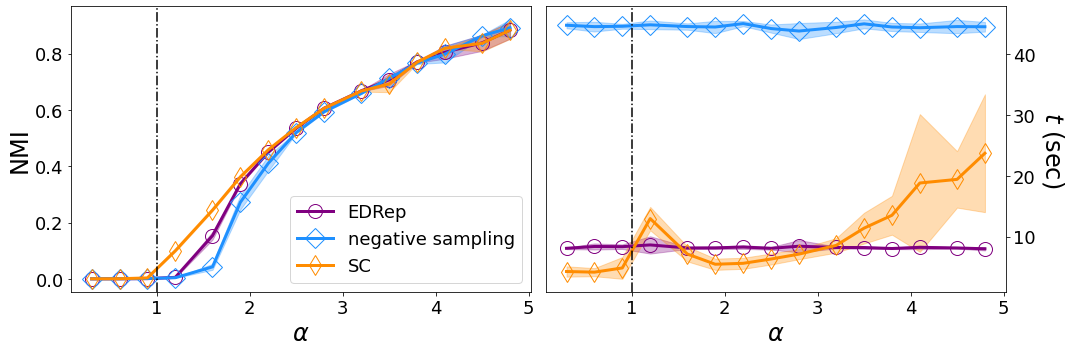

In [7]:
dfNMI_list = []
dft_list = []

for filename_NMI, filename_t in zip(os.listdir('saved_files/CD/NMI'), os.listdir('saved_files/CD/t')):
    dfNMI_list.append(pd.read_csv('saved_files/CD/NMI/' + filename_NMI))
    dft_list.append(pd.read_csv('saved_files/CD/t/' + filename_t))
    
dfNMI = pd.concat(dfNMI_list)
dfNMI.α = dfNMI.α.map(lambda x: np.round(x, 1))
dfNMI_m = dfNMI.groupby('α').mean().reset_index()
dfNMI_stdv = dfNMI.groupby('α').std().reset_index()

dft = pd.concat(dft_list)
dft.α = dft.α.map(lambda x: np.round(x, 1))
dft_m = dft.groupby('α').mean().reset_index()
dft_stdv = dft.groupby('α').std().reset_index()

colors = ['purple', 'dodgerblue', 'darkorange']
markers = ['o', 'D', 'd', '*']
ms = 14
lw = 3
names = list(dfNMI.columns[1:])
labels = ['EDRep', 'negative sampling', 'SC']

fig, ax = plt.subplots(1,2, figsize = (15, 5))

for i, (name, label) in enumerate(zip(names, labels)):

    ax[0].plot(dfNMI_m.α, dfNMI_m[name], color = colors[i], marker = markers[i], linewidth = lw,
                       markersize = ms, fillstyle = 'none', label = label)
    
    ax[0].fill_between(dfNMI_m.α, dfNMI_m[name] - dfNMI_stdv[name]/2, dfNMI_m[name] + dfNMI_stdv[name]/2,
                      color = colors[i], alpha = 0.3)


    ax[1].plot(dft_m.α, dft_m[name], color = colors[i], marker = markers[i],  linewidth = lw,
                       markersize = ms, fillstyle = 'none')
    
    ax[1].fill_between(dft_m.α, (dft_m[name] - dft_stdv[name]), (dft_m[name] + dft_stdv[name]),
                  color = colors[i], alpha = 0.3)


ax[0].axvline(1, linewidth = 1.5, linestyle = '-.', color = 'k')
ax[0].set_xlabel(r'$\alpha$', fontsize = 24)
ax[0].set_ylabel('NMI', fontsize = 24)
ax[0].tick_params(axis='both', which='major', labelsize = 18)
ax[0].legend(fontsize = 18)

ax[1].axvline(1, linewidth = 1.5, linestyle = '-.', color = 'k')
ax[1].set_xlabel(r'$\alpha$', fontsize = 24)
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].set_ylabel(r'$t~({\rm sec})$', fontsize = 24, rotation = -90, labelpad = 30)
ax[1].tick_params(axis='both', which='major', labelsize = 18)

fig.tight_layout()
plt.savefig('../../paper/v2/arXiv/Figures/ov.pdf')

plt.show();